In [1]:
import pandas as pd
import numpy as np
import utils, config
from importlib import reload
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
)
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tikzplotlib

reload(utils)
reload(config)

<module 'config' from '/Users/noahforougi/research/portfolio_optimization/config.py'>

# Accuracy of Expected Return Forecasts

In [2]:
def compute_accuracy_metrics(fc, model_columns: List[str] = config.MODEL_COLUMNS):
    results = []
    for model in model_columns:
        mae = mean_absolute_error(fc["true_value"], fc[model])
        mse = mean_squared_error(fc["true_value"], fc[model])
        medae = median_absolute_error(fc["true_value"], fc[model])
        results.append(
            {
                "Model": model,
                "Mean Absolute Error": mae,
                "Mean Squared Error": mse,
                "Median Absolute Error": medae,
            }
        )
    accuracy_df = pd.DataFrame(results)
    return accuracy_df

In [3]:
# Mapping dictionary for index names
index_mapping = {
    "btm": "Book-to-Market",
    "industry": "Industry",
    "momentum": "Momentum",
    "size": "Size",
    "size_ltr": "Size and Long-Term Reversal",
    #'size_str': 'Size and Short-Term Reversal',
    "sizebtm": "Size and Book-to-Market",
    "sizemomentum": "Size and Momentum",
}

# Desired order for model columns
desired_order = [
    "ModelType.ROLLING_AVERAGE",
    "ModelType.EWMA",
    "ModelType.LINEAR_REGRESSION",
    "ModelType.RIDGE_REGRESSION",
    "ModelType.LASSO_REGRESSION",
    "ModelType.SVR",
    "ModelType.GRADIENT_BOOSTING",
    "ModelType.RANDOM_FOREST",
    "ModelType.XGBOOST",
]

In [4]:
al = list()
er_forecasts = [x for x in utils.list_s3_files("output/") if ".csv" in x]
for f in er_forecasts:
    clean_f = f.replace("output/er_forecasts_", "").replace(".csv", "")
    fc_df = utils.read_s3_file(f)
    tmp = compute_accuracy_metrics(fc_df).assign(portfolio=clean_f)
    al.append(tmp)
accuracy_df = pd.concat(al)

In [5]:
accuracy_df = pd.concat(al).loc[lambda x: x.portfolio != "size_str"]
accuracy_df["portfolio"] = accuracy_df["portfolio"].map(index_mapping)
msfe_table = accuracy_df.pivot(
    index="portfolio", columns="Model", values="Mean Squared Error"
)
msfe_table = msfe_table[desired_order]
msfe_table

Model,ModelType.ROLLING_AVERAGE,ModelType.EWMA,ModelType.LINEAR_REGRESSION,ModelType.RIDGE_REGRESSION,ModelType.LASSO_REGRESSION,ModelType.SVR,ModelType.GRADIENT_BOOSTING,ModelType.RANDOM_FOREST,ModelType.XGBOOST
portfolio,,,,,,,,,
Book-to-Market,0.002634,0.002856,0.009099,0.005864,0.002672,0.003013,0.002759,0.003001,0.002766
Industry,0.003290,0.003566,0.008935,0.005783,0.003280,0.003449,0.003426,0.003614,0.003373
Momentum,0.003699,0.004023,0.013131,0.007620,0.003697,0.003858,0.003878,0.004185,0.003858
Size,0.003261,0.003568,0.015018,0.007935,0.003263,0.003587,0.003404,0.003817,0.003375
Size and Book-to-Market,0.003168,0.003456,0.014193,0.005771,0.003171,0.003550,0.003312,0.003554,0.003301
Size and Long-Term Reversal,0.003037,0.003332,0.043166,0.009691,0.003033,0.003307,0.003212,0.003425,0.003149
Size and Momentum,0.003778,0.004124,0.140512,0.030700,0.003778,0.004100,0.003819,0.004124,0.003810


/var/folders/h6/x8xtcdbj30q6yb889t6pcbq00000gn/T/ipykernel_59135/1829491861.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(msfe_mean.index, rotation=0, fontsize=12)
/var/folders/h6/x8xtcdbj30q6yb889t6pcbq00000gn/T/ipykernel_59135/1829491861.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{y:.3f}' for y in ax.get_yticks()], fontsize=12)


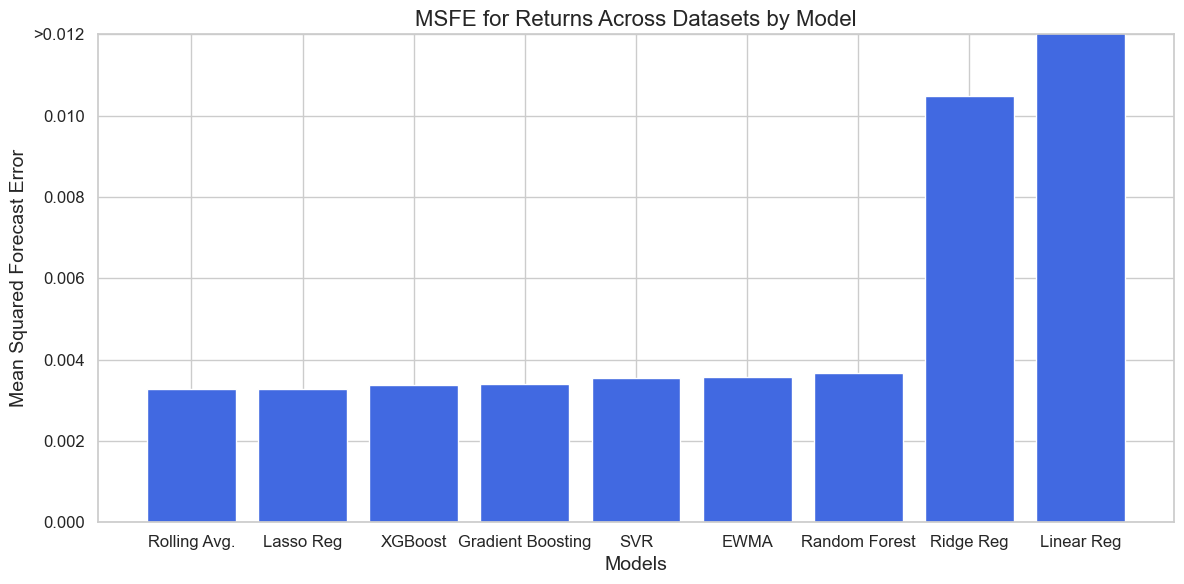

In [13]:
def forecast_error_plot(msfe_table):
    msfe_mean = msfe_table.mean().sort_values()
    model_name_mapping = {
        "ModelType.ROLLING_AVERAGE": "Rolling Avg.",
        "ModelType.EWMA": "EWMA",
        "ModelType.LINEAR_REGRESSION": "Linear Reg",
        "ModelType.RIDGE_REGRESSION": "Ridge Reg",
        "ModelType.LASSO_REGRESSION": "Lasso Reg",
        "ModelType.SVR": "SVR",
        "ModelType.GRADIENT_BOOSTING": "Gradient Boosting",
        "ModelType.RANDOM_FOREST": "Random Forest",
        "ModelType.XGBOOST": "XGBoost",
    }
    msfe_mean.index = [model_name_mapping.get(name, name) for name in msfe_mean.index]

    second_highest_value = msfe_mean.nlargest(2).min()

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(msfe_mean.index, msfe_mean.values, color="royalblue")

    ax.set_xticklabels(msfe_mean.index, rotation=0, fontsize=12)
    ax.set_yticklabels([f"{y:.3f}" for y in ax.get_yticks()], fontsize=12)

    ax.set_xlabel("Models", fontsize=14)
    ax.set_ylabel("Mean Squared Forecast Error", fontsize=14)
    ax.set_title("MSFE for Returns Across Datasets by Model", fontsize=16)

    ax.set_ylim(0, second_highest_value * 1.1)

    y_ticks = ax.get_yticks()
    y_labels = [f"{y:.3f}" for y in y_ticks]
    y_labels[-1] = f">{y_labels[-1]}"
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    fig.tight_layout()
    tikzplotlib.save("../writing/figures/er_msfe.tex")
    plt.show()


forecast_error_plot(msfe_table)

# Accuracy of Covariance Matrix Forecasts

In [ ]:
def calc_msfe(realized, forecast):
    forecast_array = np.array(forecast)
    if forecast_array.dtype.kind in "iufc":
        if np.isnan(forecast_array).all():
            return np.nan
    else:
        return np.nan
    realized_array = np.array(realized, dtype=float)
    sfe = (forecast_array - realized_array) ** 2
    return np.triu(sfe).sum()

In [ ]:
cov_forecasts = [x for x in utils.list_s3_files("output/") if ".pkl" in x]

In [ ]:
all_results = list()
for f in tqdm(cov_forecasts):
    cov_fc = utils.read_s3_joblib(f)
    clean_f = f.replace("output/cov_forecasts_", "").replace(".pkl", "")
    results = list()
    for d in tqdm(cov_fc):
        # Calculate MSFE for each method
        msfe_values = pd.DataFrame(
            data={
                "Rolling Average": calc_msfe(d.get("true_cov"), d.get("cov_ra")),
                "Shrinkage": calc_msfe(d.get("true_cov"), d.get("cov_lw_shrinkage")),
                "EWMA": calc_msfe(d.get("true_cov"), d.get("cov_ewma")),
                "DCC-GARCH": calc_msfe(d.get("true_cov"), d.get("cov_dcc")),
                "GO-GARCH": calc_msfe(d.get("true_cov"), d.get("cov_gogarch")),
            },
            index=[d.get("date")],
        )
        # Append the result to the list
        results.append(msfe_values)
    cov_accuracy_df = (
        pd.DataFrame(pd.concat(results).mean())
        .rename(columns={0: "Mean Squared Error"})
        .T.assign(portfolio=clean_f)
    )
    all_results.append(cov_accuracy_df)

In [ ]:
total_cov_accuracy_df = pd.concat(all_results).loc[lambda x: x.portfolio != "size_str"]
total_cov_accuracy_df["portfolio"] = total_cov_accuracy_df["portfolio"].map(
    index_mapping
)
total_cov_accuracy_df = total_cov_accuracy_df.reset_index(drop=True).set_index(
    "portfolio"
)

In [ ]:
total_cov_accuracy_df

In [ ]:
total_cov_accuracy_df_plot = total_cov_accuracy_df.mean().sort_values()
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
barplot = sns.barplot(
    x=total_cov_accuracy_df_plot.index,
    y=total_cov_accuracy_df_plot.values,
    color="royalblue",
)
plt.xticks(rotation=0, fontsize=12)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Mean Squared Forecast Error", fontsize=14)
plt.title("Mean MSFE for Covariance Matrices by Model", fontsize=16)
plt.tight_layout()
plt.show()
import matplotlib2tikz

matplotlib2tikz.save("../writing/figures/cov_msfe.tex")